In [11]:
#To show images 
%matplotlib notebook
%matplotlib notebook
#Libraries
import heapq
import random
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

#For animation
from matplotlib.animation import PillowWriter
import matplotlib.animation as animation
from matplotlib import colors

In [12]:
'''
Class to deal with cell-level events.
Includes initialising the type of cell,
Adding and removing people,
Comparing cells to one another, etc
'''

class Cell(object):
    def __init__(self,position,cell_type,parent=None):
        
        #Coordinates 
        self.x=position[0]
        self.y=position[1]
        
        #Type of cell
        # 1 for person, 2 for obstacle, 3 for exit
        self.cell_type = cell_type
        
        #Variables to find shortest path
        self.position = [self.x, self.y]
        self.g = 0.0 #cost s
        self.f = 0.0 #cost
        self.opened = 0
        self.closed = False
        self.parent= parent

    
    #Compares the distance of 1 cell to a goal destination
    #with the distance of another cell to goal destination
    def __lt__(self, compare):
        return self.f < compare.f
        
    #Add person to cell
    def add(self):
        self.type=1
    
    #Remove person from cell
    def delete(self):
        self.type=0
    
    #reset values for the cell 
    def reset(self):
        
        self.g = 0.0 #cost from the start to this cell
        self.f = 0.0 #distance from start to this point
        
        self.opened = 0
        self.closed = False
        
        self.parent= None
    


In [13]:
'''
Class to create create our cellular automata matrix.
Includes methods to display the grid, update the grid,
Return a list of walkable neighbours, check if cell
is within the boundaries

'''

class Matrix(object):
    
    #Initialise
    def __init__(self,matrix):
        self.matrix=matrix
        cells=[]
        
        #n is columns
        #m is rows
        m = matrix.shape[0]
        n = matrix.shape[1]
        
        #For the entire grid
        for i in range(m):
            cells.append([])
            for j in range(n):
                
                if matrix[i][j]==0:
                    cell_type = 0
                
                #a person is a 1
                if matrix[i][j]==1:
                    cell_type = 1
                    
                #an obstacle is a 2
                if matrix[i][j]==2:
                    cell_type = 2
                     
                #an exit is a 3
                if matrix[i][j]==3:
                    cell_type = 3
                    
            
                cells[i].append(Cell((i,j),cell_type))
        self.cells=cells
    
    #position 
    def cell(self,x,y):
        return self.cells[x][y]
    
    #Display matrix
    def display(self):
        plt.figure(figsize=(5,5))
        plt.imshow(self.matrix)
    
    #Update matrix after timestep
    def update(self):
        
        m,n=self.matrix.shape
        matrix=np.zeros((m,n))
        
        #For all cells
        for i in range(m):
            for j in range(n):
                #person
                if self.cell(i,j).cell_type==1:
                    matrix[i][j]= 1
                #obstacle
                elif self.cell(i,j).cell_type==2:
                    matrix[i][j]= 2
                #exit
                elif self.cell(i,j).cell_type==3:
                    matrix[i][j]= 3
        self.matrix=matrix
        
    #Check if within boundaries   
    def boundaries(self,x,y):
        if (x>=0 and x<self.matrix.shape[0]) and (y>=0 and y<self.matrix.shape[1]):
            return True
        else: 
            return False
    
    #check if you can walk in a cell    
    def can_walk(self,x,y):
        #in boundary, not an obstacle, not a person
        if self.boundaries(x,y) and self.cells[x][y].cell_type != 2 and self.cells[x][y].cell_type != 1:
                return True
        #else, we cannot walk there
        else:
                return False
                    
    #find neighbours of a cell
    def neighbours(self,cell):
        
        x=cell.x
        y=cell.y
        neighbours=[]
        
        #look at the 8 possible neighbours and check
        #if they are walkable, we add them to array
        for xd in [0,1,-1]:
            for yd in [-1,0,1]:
                if self.can_walk(x+xd,y+yd) and not (xd ==0 and yd==0):
                    neighbours.append(self.cells[x+xd][y+yd])
                               
        return neighbours 
    
    #clean the attributes of cells in grid
    def reset(self):
        for x in self.cells:
            for cell in x:
                cell.reset() 

In [ ]:
'''
Class to find a path between a current position and goal destination
Includes calculations of the cost of distances, pathfinding


'''
class Path(object):
    
    def __init__(self,grid,start,end):
        self.grid=grid
        self.start=start
        self.end=end
    
    #returns all neighbours
    #that we calculated in grid class
    def list_neighbours(self, cell):
        return self.grid.neighbours(cell)
    
    #calculates cost to get to neighbour  
    #from start node 
    def g_score(self,a,b):
        if b.x-a.x == 0 or b.y-a.y == 0: #direct neighbour
            g=1
        else:
            #diagonal neighbour
            #uses pythagorus 
            g=2**0.5
        return cell1.g+g # cumulatively add up all g scores on path 
    
    #Calculates the costs associated with the specific path we are on 
    def scores(self,cell,parent,end,open_list):   
        new_g_score = self.g_score(parent, cell)
        
        #If we have found a better path 
        if not cell.opened or new_g_score < cell.g:
            cell.g = new_g_score #we should use this better path 
            cell.f = cell.g # our new g_score is the new estimated cost of our path to the end
            cell.parent = parent

            #if cell has not yet been visited in open list
            if not cell.opened:
                heapq.heappush(open_list, cell) #push this cell into the open list heap
                cell.opened=True #and mark it as opened 
            else:
                # the node can be reached with smaller cost.
                # Since its f value has been updated, we have to
                # update its position in the open list
                open_list.remove(cell)
                heapq.heappush(open_list, cell)
                
    #Uses Dijkstras Algorithm to find the best path
    def dijkstra(self):
        start=self.start
        end=self.end
        start.opened=True
        
        open_list=[start]
        current_cell=start
        infinite_loop_checker = 0
        #Run until we reach our destination cell 
        while current_cell != end:
            
            #If we have 1 or less cells to visit
            #we have reached our end cell!
            if len(open_list)<1:
                current_cell==end
            
            #But if not, we need to keep searching 
            else:
                #We look at the first element in our open list
                current_cell=heapq.nsmallest(1,open_list)[0]
                #And move it to our closed list 
                open_list.remove(current_cell)
                current_cell.closed=True
                
                #We find all of its neighbours
                neighbors = self.list_neighbours(current_cell)
                for neighbor in neighbors:
                    if neighbor.closed:
                        continue
                    #and compute the associated costs with each of them
                    #to best be able to choose which path to visit 
                    self.scores(neighbor,current_cell,end,open_list)
            
            #Check we are not running forever
            infinite_loop_checker+=1
            if infinite_loop_checker > 10000:
                return("Cannot find path!")
        
        #how far we traveled 
        length=current_cell.f
        
        #SUCCESS
        #We have reached our destination, now we loop through the parents
        #of all the cells we visited to find the path we travelled
        path = [(current_cell.x,current_cell.y)]
        while current_cell.parent:
            current_cell = current_cell.parent
            path.append((current_cell.x,current_cell.y))
        path = path.reverse
        
        #reset for next time
        self.grid.reset()
        
        #return the best path and the length of it 
        return path,length

In [ ]:
'''
Class that uses all the previous classes and 
evacuates the room!
'''
class Simulation(object):
  
    def __init__(self, matrix):
        self.grid=Matrix(matrix)
        self.n_students=len(self.parameters()[0]) #we will need to evacuate all people 
        self.to_display=[]
        self.time=0
        self.moves=0
    
    #Function to take a look at our matrix
    #Includes stored values to use in animations 
    def visualise(self):
        self.to_display.append(self.grid.matrix)
        return self.grid
    
    #function to tell us which people and exits
    #are in our simulation 
    def parameters(self):
        students=[]
        exits=[]
        
        for i in self.grid.cells:
            for j in x:
                if j.cell_type==1: #append students
                    students.append(j)
                if if j.cell_type==3: #append exits 
                    exits.append(j)
        
        return students, exits
    
    #function to determine which exit a person should go to
    def which_exit(self,person,exits):
        route=0
        dist=10000000000 #initialise
        
        #evaluate route for each exit 
        for i in exits:
            d=Path(self.grid,person,i)
            path=d.dijkstrah()
            if path[1]<dist: #path[1] is distance of path
                #so if we have a shorter distance to next exit
                #we will choose it 
                
                route=path[0] #stores cells visited on path 
                dist=path[1] #stores length of path 
        return best_path
    
    #This function moves one student, one step 
    #on their desired path 
    def move_person(self,student,desired_path):
        if isinstance(desired_path,list): #if we can move them
            next_cell=self.grid.cell(desired_path[1][0],desired_path[1][1])
            next_cell.add() #add person to next cell
            student.delete() #delete from previous cell
        else:
            next_cell=person #we cannot move them 
            
        if next_cell.cell_type==3: #if at exit, remove
            next_cell.delete()
            self.n_students-=1
        
    
    #Move each student 
    #One timestep along their 
    #optimised timestep
    def time_step(self,students,exits):
        random.shuffle(students) #random order of movement
        for i in students:
            go_exit=self.which_exit(i,exits)
            self.move_person(i,go_exit) #move person to the optimal exit for them 
        
    #Code to simulate,
    #to empty the room of all students
    #through their optimal exits
    def empty_room(self):
        exits=self.parameters()[1] #exits
        #While room still has students
        while self.n_students>0: 
            students=self.parameters()[0] #people
            self.time_step(students,exits) #move each person 1 step
            self.grid.update() #update grid, helps with visualising
            self.visualise() #store our updates for visualising
            self.grid.display() #display
        return self.grid


In [ ]:
'''
Testing to see how rules work 
Empty grid
'''
a=np.zeros((10,10))

#People
a[3][3]=1
a[4][4]=1

#Exits 
a[0][0]=3
a[9][9]=3

gr = Matrix(a)
gr.display()
s = Simulation(a)

s.empty_room()

In [ ]:
'''
Function to add students to classroom with desks
and door already there 
''' 
def add_students(matrix,n):
    #creates matrix with n people randomly
    #positioned in open sports 
    i,j=matrix.shape
    size=i*j
    student_counter=0
    
    #loop until we have added n students
    while student_counter<n
        
        #randomly choose a block to add a person to
        x,y=(random.randint(0,i),random.randint(0,j))
        
        #check if the block is empty 
        if matrix[x][y]!=1 and matrix[x][y]!=2 and matrix[x][y]!=3:
            #if so, add a person 
            matrix[x][y]=1
            student_counter+=1

# Experiments: different desk layouts 


<IPython.core.display.Javascript object>


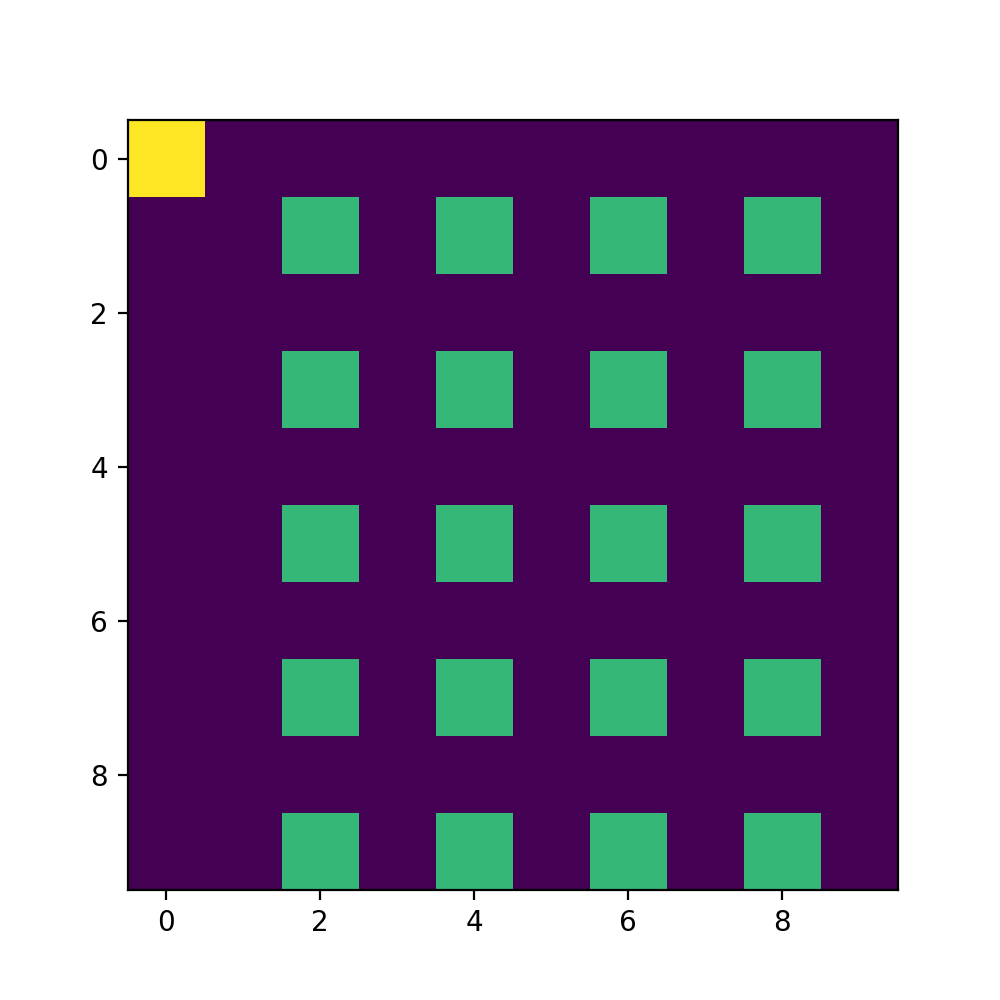

In [14]:
#single desks 
a1=np.zeros((10,10))
a1[0][0]=3 #exit 
for i in range(1,10):
    for j in range(1,10):
        if not i%2==0 and j%2==0:
            a1[i][j]=2

gr=Matrix(a1)
gr.display()

<IPython.core.display.Javascript object>


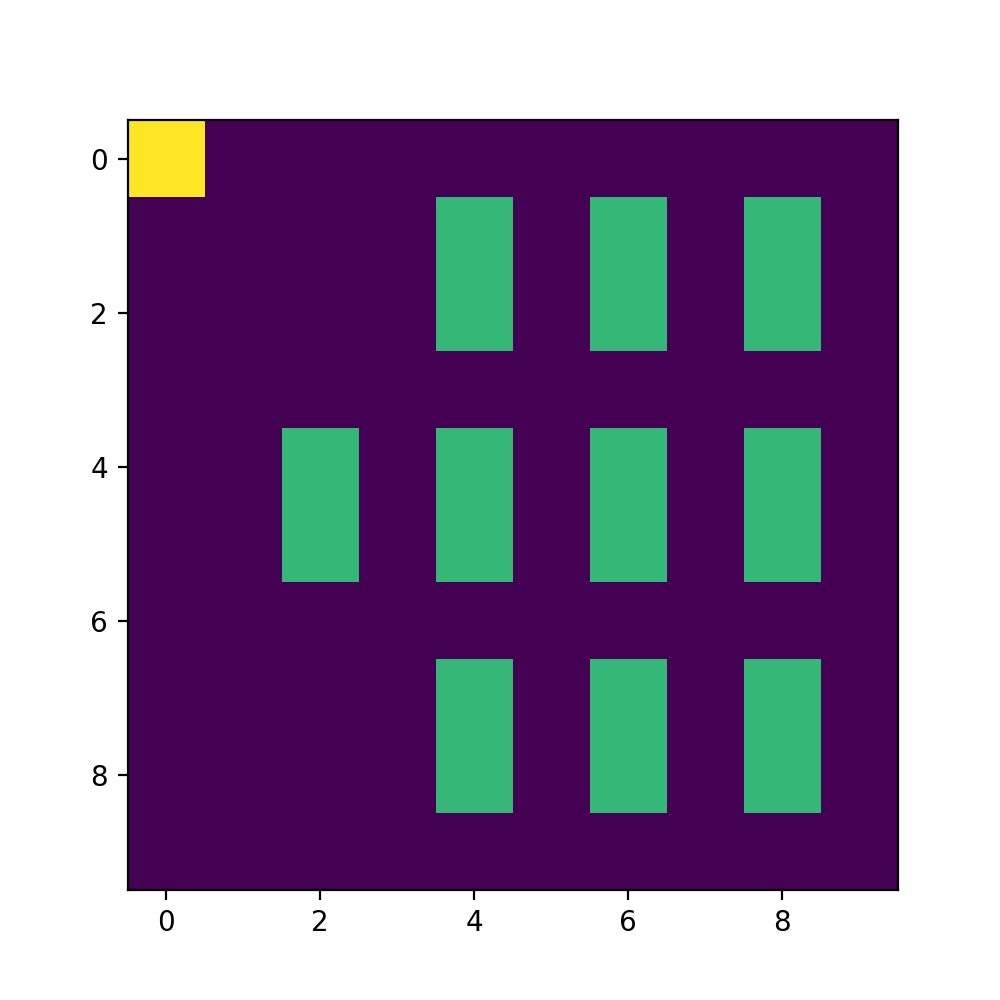

In [15]:
#double desks 
a2=np.zeros((10,10))
a2[0][0]=3 #exit 
for i in range(1,10):
    for j in range(1,10):
        if not i%3==0 and j%2==0:
            a2[i][j]=2
a2[8][2]=0
a2[7][2]=0
a2[1][2]=0
a2[2][2]=0

gr=Matrix(a2)
gr.display()

<IPython.core.display.Javascript object>


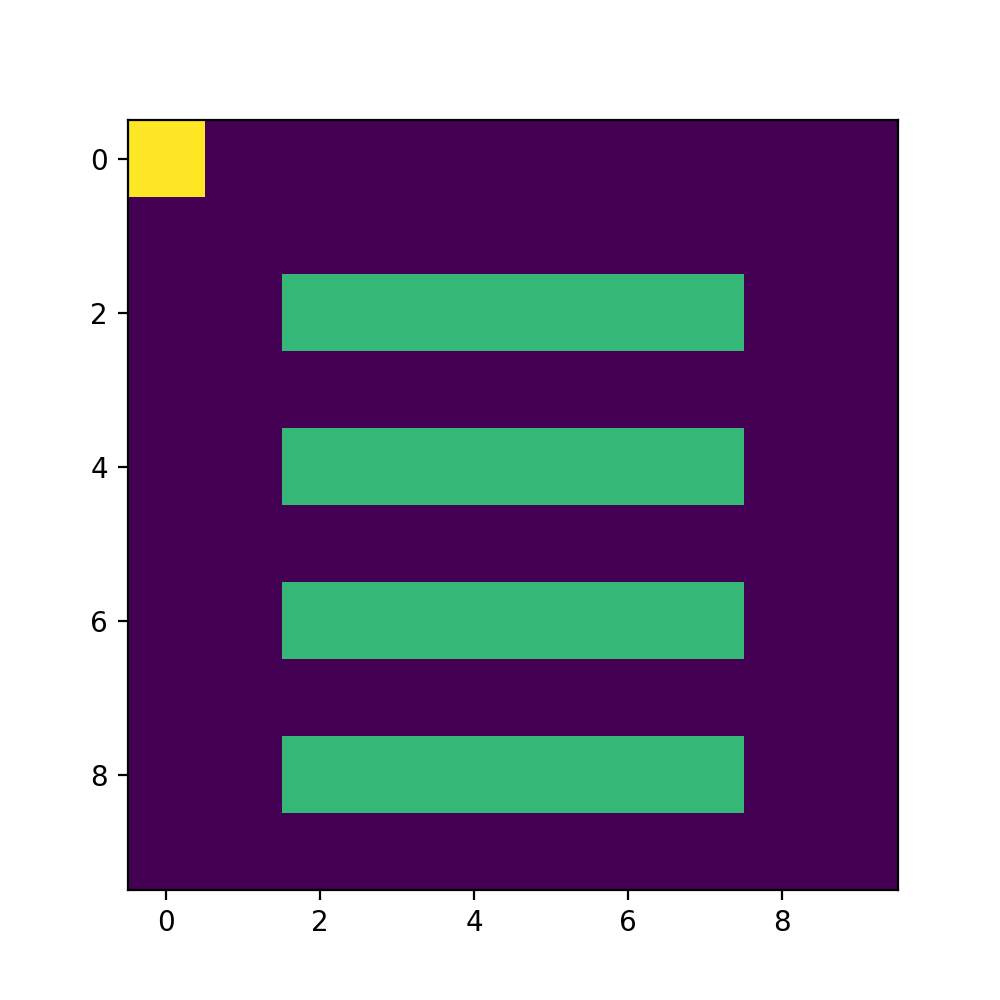

In [27]:
#Triple desks
a3=np.zeros((10,10))
a3[0][0]=3 #exit 

#desks
a3[2][2:8]=2
a3[4][2:8]=2
a3[6][2:8]=2
a3[8][2:8]=2

gr=Matrix(a3)
gr.display()

In [17]:
'''
The following is used to create gifs
and was taken from the documentation on the library 
as well as stackoverflow
https://stackoverflow.com/questions/51512141/how-to-make-matplotlib-saved-gif-looping
'''

class LoopingPillowWriter(PillowWriter):
    """
    Animation class for GIF export

    """
    #to help create gif
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)
#to animate        
def animate(matrices,interval):
   
    fig = plt.figure()

    ims=[]
    cmap=colors.ListedColormap(['purple','green','yellow','grey'])
    norm=colors.BoundaryNorm(bounds,cmap.N)
    bounds=[0,1,2,3,4]
    for i in matrices:
        im = plt.imshow(i, animated=True, norm=norm,cmap=cmap)

        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True,
                                    repeat_delay=1000)
    
    return ani
#write to help gif
writer = LoopingPillowWriter(fps=20)


In [ ]:
#sets up people and create gifs
add_students(a1,20)
add_students(a2,20)
add_students(a3,20)

#simulate 
sim1=Simulation(a1)
sim1.empty_room()
grid1=sim1.to_display

sim2=Simulation(a2)
sim2.empty_room()
grid2=sim2.to_display

sim3=Simulation(a3)
sim3.empty_room()
matrices3=sim3.to_display

#animation for each of the 3
animation1=animate(grid1,20)
animation1.save("one.gif", writer=writer) 

animation2=animate(grid2,20)
animation2.save("two.gif", writer=writer) 

animation3=animate(matrices3,20)
animation3.save("three.gif", writer=writer) 

# Histograms for 3 classroom setups

In [ ]:
store1 = []
for i in range(50):
    
    #set up config 1
    a1=np.zeros((10,10))
    a1[0][0]=2 #exit 
    for i in range(1,10):
        for j in range(1,10):
            if not i%3==0 and j%2==0:
                a1[i][j]=1
    a1[8][2]=0
    a1[7][2]=0
    a1[1][2]=0
    a1[2][2]=0

    add_students(a1,20)
    
    
   
    simb1=Simulation(a1)
    simb1.empty_room()
    store1.append(simb1.movement())

In [ ]:
store2 = []
for i in range(50):
    
    #set up config 2
    a2=np.zeros((10,10))
    a2[0][0]=2 #exit 
    for i in range(1,10):
        for j in range(1,10):
            if not i%3==0 and j%2==0:
                a2[i][j]=1
    a2[8][2]=0
    a2[7][2]=0
    a2[1][2]=0
    a2[2][2]=0
    
    #add 20 people to the matrix 
    add_students(a2,20)
   
    simb2=Simulation(a2)
    simb2.empty_room()
    store2.append(simb2.movement())

In [ ]:
store3 = []
for i in range(50):
    
    #set up config 3
    matrix = np.zeros((10,10))
    matrix[0][0]=2 #exit 

    matrix[2][2:8]=1
    matrix[4][2:8]=1
    matrix[6][2:8]=1
    matrix[8][2:8]=1
    
    #add 20 people to the matrix 
    add_students(matrix,20)
   
    simb3=Simulation(matrix)
    simb3.empty_room()
    store.append(simb3.movement())

In [25]:
plt.hist(store1, alpha=0.5, label = 'Single')
plt.hist(store2, alpha=0.5, label = 'Double')
plt.hist(store3, alpha=0.5, label = 'Rows')
plt.legend()
plt.title('Steps taken to fully evacuate classroom with 3 different desk layouts')
plt.show()

<IPython.core.display.Javascript object>


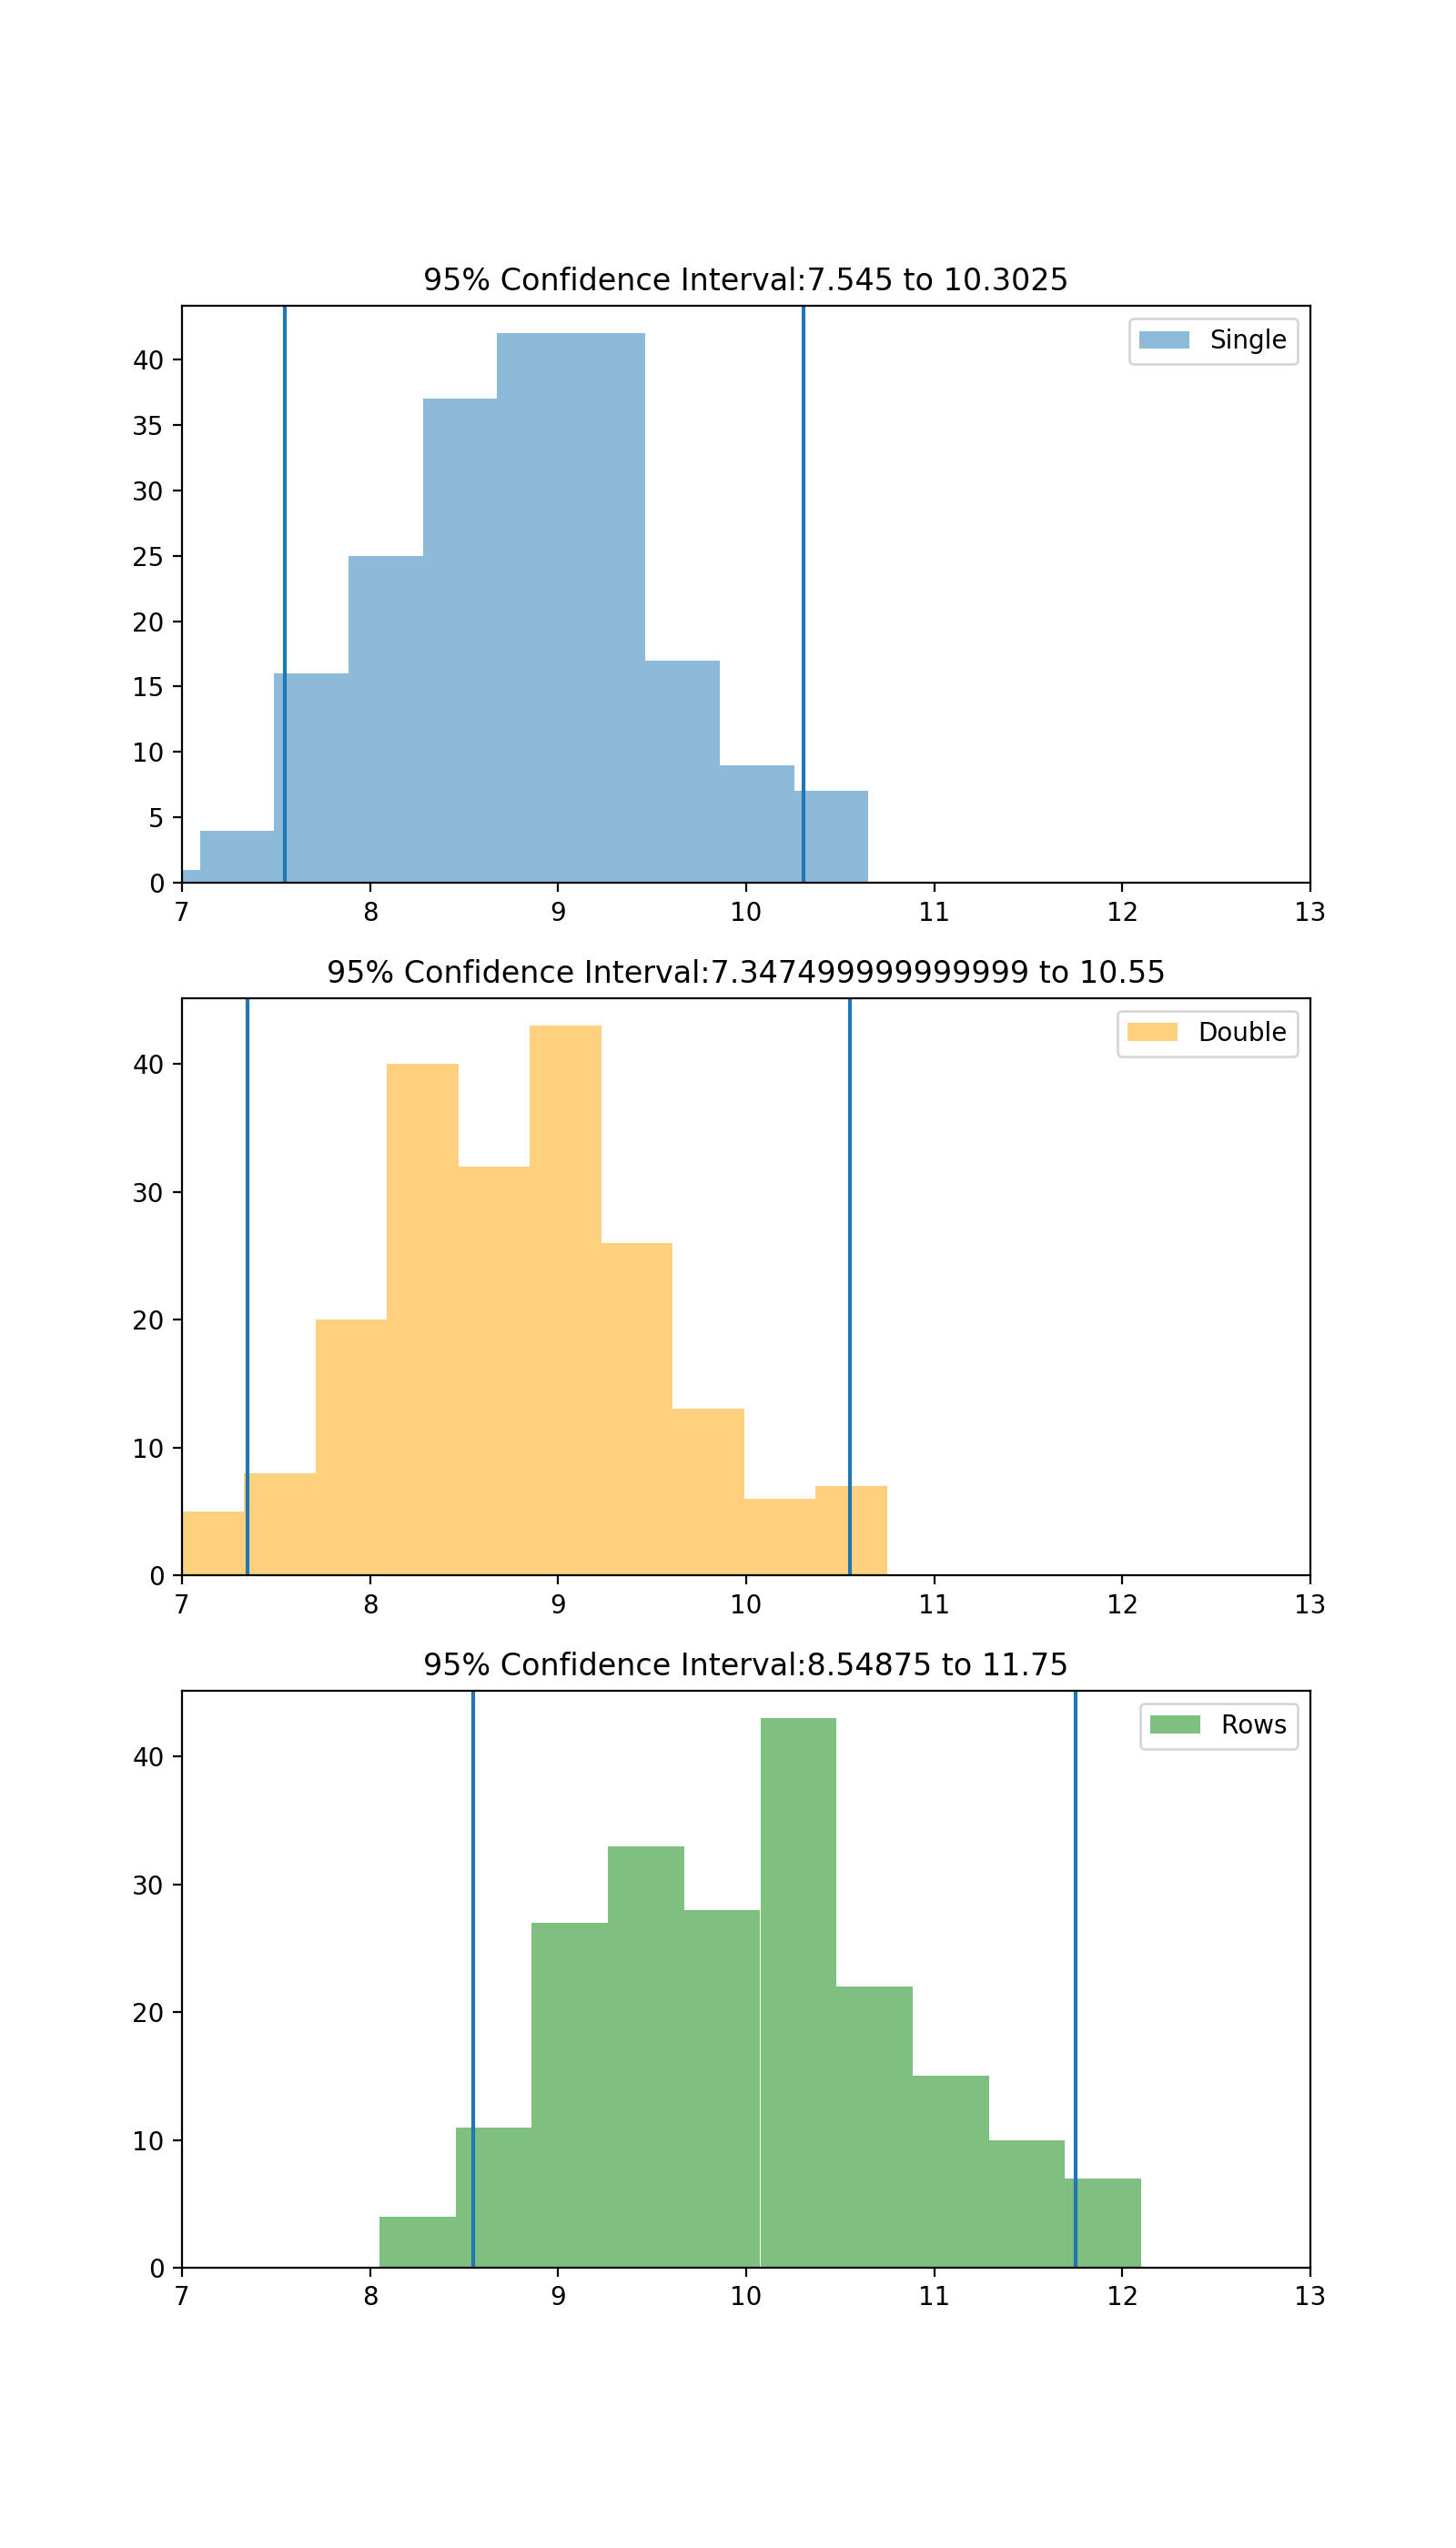

In [26]:
fig1a= plt.figure(figsize=(8,14))
plt.subplot(3, 1, 1)
plt.xlim((7, 13))
plt.hist(store1, alpha=0.5, label = 'Single')
plt.axvline(np.percentile(store1,2.5))
plt.axvline(np.percentile(store1,97.5))
plt.legend()
plt.title('95% Confidence Interval:'+str(np.percentile(store1,2.5))+' to '+str(np.percentile(store1,97.5)))

plt.subplot(3, 1, 2)
plt.hist(store2, alpha=0.5, label = 'Double', color = 'orange')
plt.xlim((7, 13))
plt.axvline(np.percentile(store2,2.5))
plt.axvline(np.percentile(store2,97.5))
plt.legend()
plt.title('95% Confidence Interval:'+str(np.percentile(store2,2.5))+' to '+str(np.percentile(store2,97.5)))


plt.subplot(3, 1, 3)
plt.hist(store3, alpha=0.5, label = 'Rows', color = 'green')
plt.xlim((7, 13))
plt.axvline(np.percentile(store3,2.5))
plt.axvline(np.percentile(store3,97.5))
plt.legend()
plt.title('95% Confidence Interval:'+str(np.percentile(store3,2.5))+' to '+str(np.percentile(store3,97.5)))

plt.show()
fig1a.savefig('fig1a.png')


# Experiments: renovating exits 

In [ ]:
#setup1
a1=np.zeros((10,10))
a1[0][0]=2 #exit 

for i in range(1,10):
    for j in range(1,10):
        if not i%2==0 and j%2==0:
            a1[i][j]=1

gr=Matrix(a1)
gr.display()

#add 20 people to the matrix 
add_students(a1,20)

#simulate
sim1=Simulation(a1)
sim1.empty_room()
grid1=sim1.to_display

#animation
animation2=animate(grid,30)
animation2.save("single.gif", writer=writer) 

In [ ]:
#setup2
a1=np.zeros((10,10))
a1[0][0]=2 #exit 
a1[1][0]=2 #exit
for i in range(1,10):
    for j in range(1,10):
        if not i%2==0 and j%2==0:
            a1[i][j]=1


gr=Matrix(a1)
gr.display()

#add 20 people to the matrix 
add_students(a1,20)

#simulate
sim1=Simulation(a1)
sim1.empty_room()
grid1=sim1.to_display

#animation
animation2=animate(grid,30)
animation2.save("two_door.gif", writer=write

In [ ]:
#setup3
a1=np.zeros((10,10))
a1[0][0]=2 #exit 
a1[9][0]=2
for i in range(1,10):
    for j in range(1,10):
        if not i%2==0 and j%2==0:
            a1[i][j]=1

gr=Matrix(a1)
gr.display()

#add 20 people to the matrix 
add_students(a1,20)

#simulate
sim1=Simulation(a1)
sim1.empty_room()
grid1=sim1.to_display

#animation
animation2=animate(grid,30)
animation2.save("double_door.gif", writer=write

In [ ]:
#samples for config 2

store_b = []
for i in range(200):
    
    #set up config 2
    a1=np.zeros((10,10))
    a1[0][0]=2 #exit 
    a1[1][0]=2 #exit
    for i in range(1,10):
        for j in range(1,10):
            if not i%2==0 and j%2==0:
                a1[i][j]=1
    
    #add 20 people to the matrix 
    add_students(a1,20)
   
    simb3=Simulation(a1)
    simb3.empty_room()
    store_b.append(simb3.movement())


In [ ]:
#samples for config 3

store_c = []
for i in range(200):
    
    #set up config 2
    a1=np.zeros((10,10))
    a1[0][0]=2 #exit 
    a1[9][0]=2
    for i in range(1,10):
        for j in range(1,10):
            if not i%2==0 and j%2==0:
                a1[i][j]=1
    
    #add 20 people to the matrix 
    add_students(a1,20)
   
    simb3=Simulation(a1)
    simb3.empty_room()
    store_c.append(simb3.movement())
  

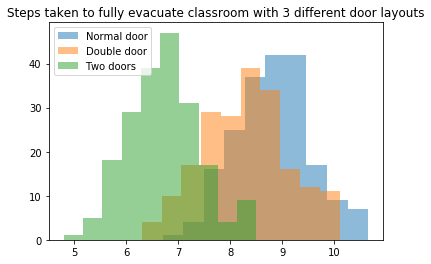

In [5]:
import matplotlib.pyplot as plt
plt.hist(store1, alpha=0.5, label = 'Normal door')
plt.hist(store_b, alpha=0.5, label = 'Double door')
plt.hist(store_c, alpha=0.5, label = 'Two doors')
plt.legend()
plt.title('Steps taken to fully evacuate classroom with 3 different door layouts')
plt.show()

<IPython.core.display.Javascript object>


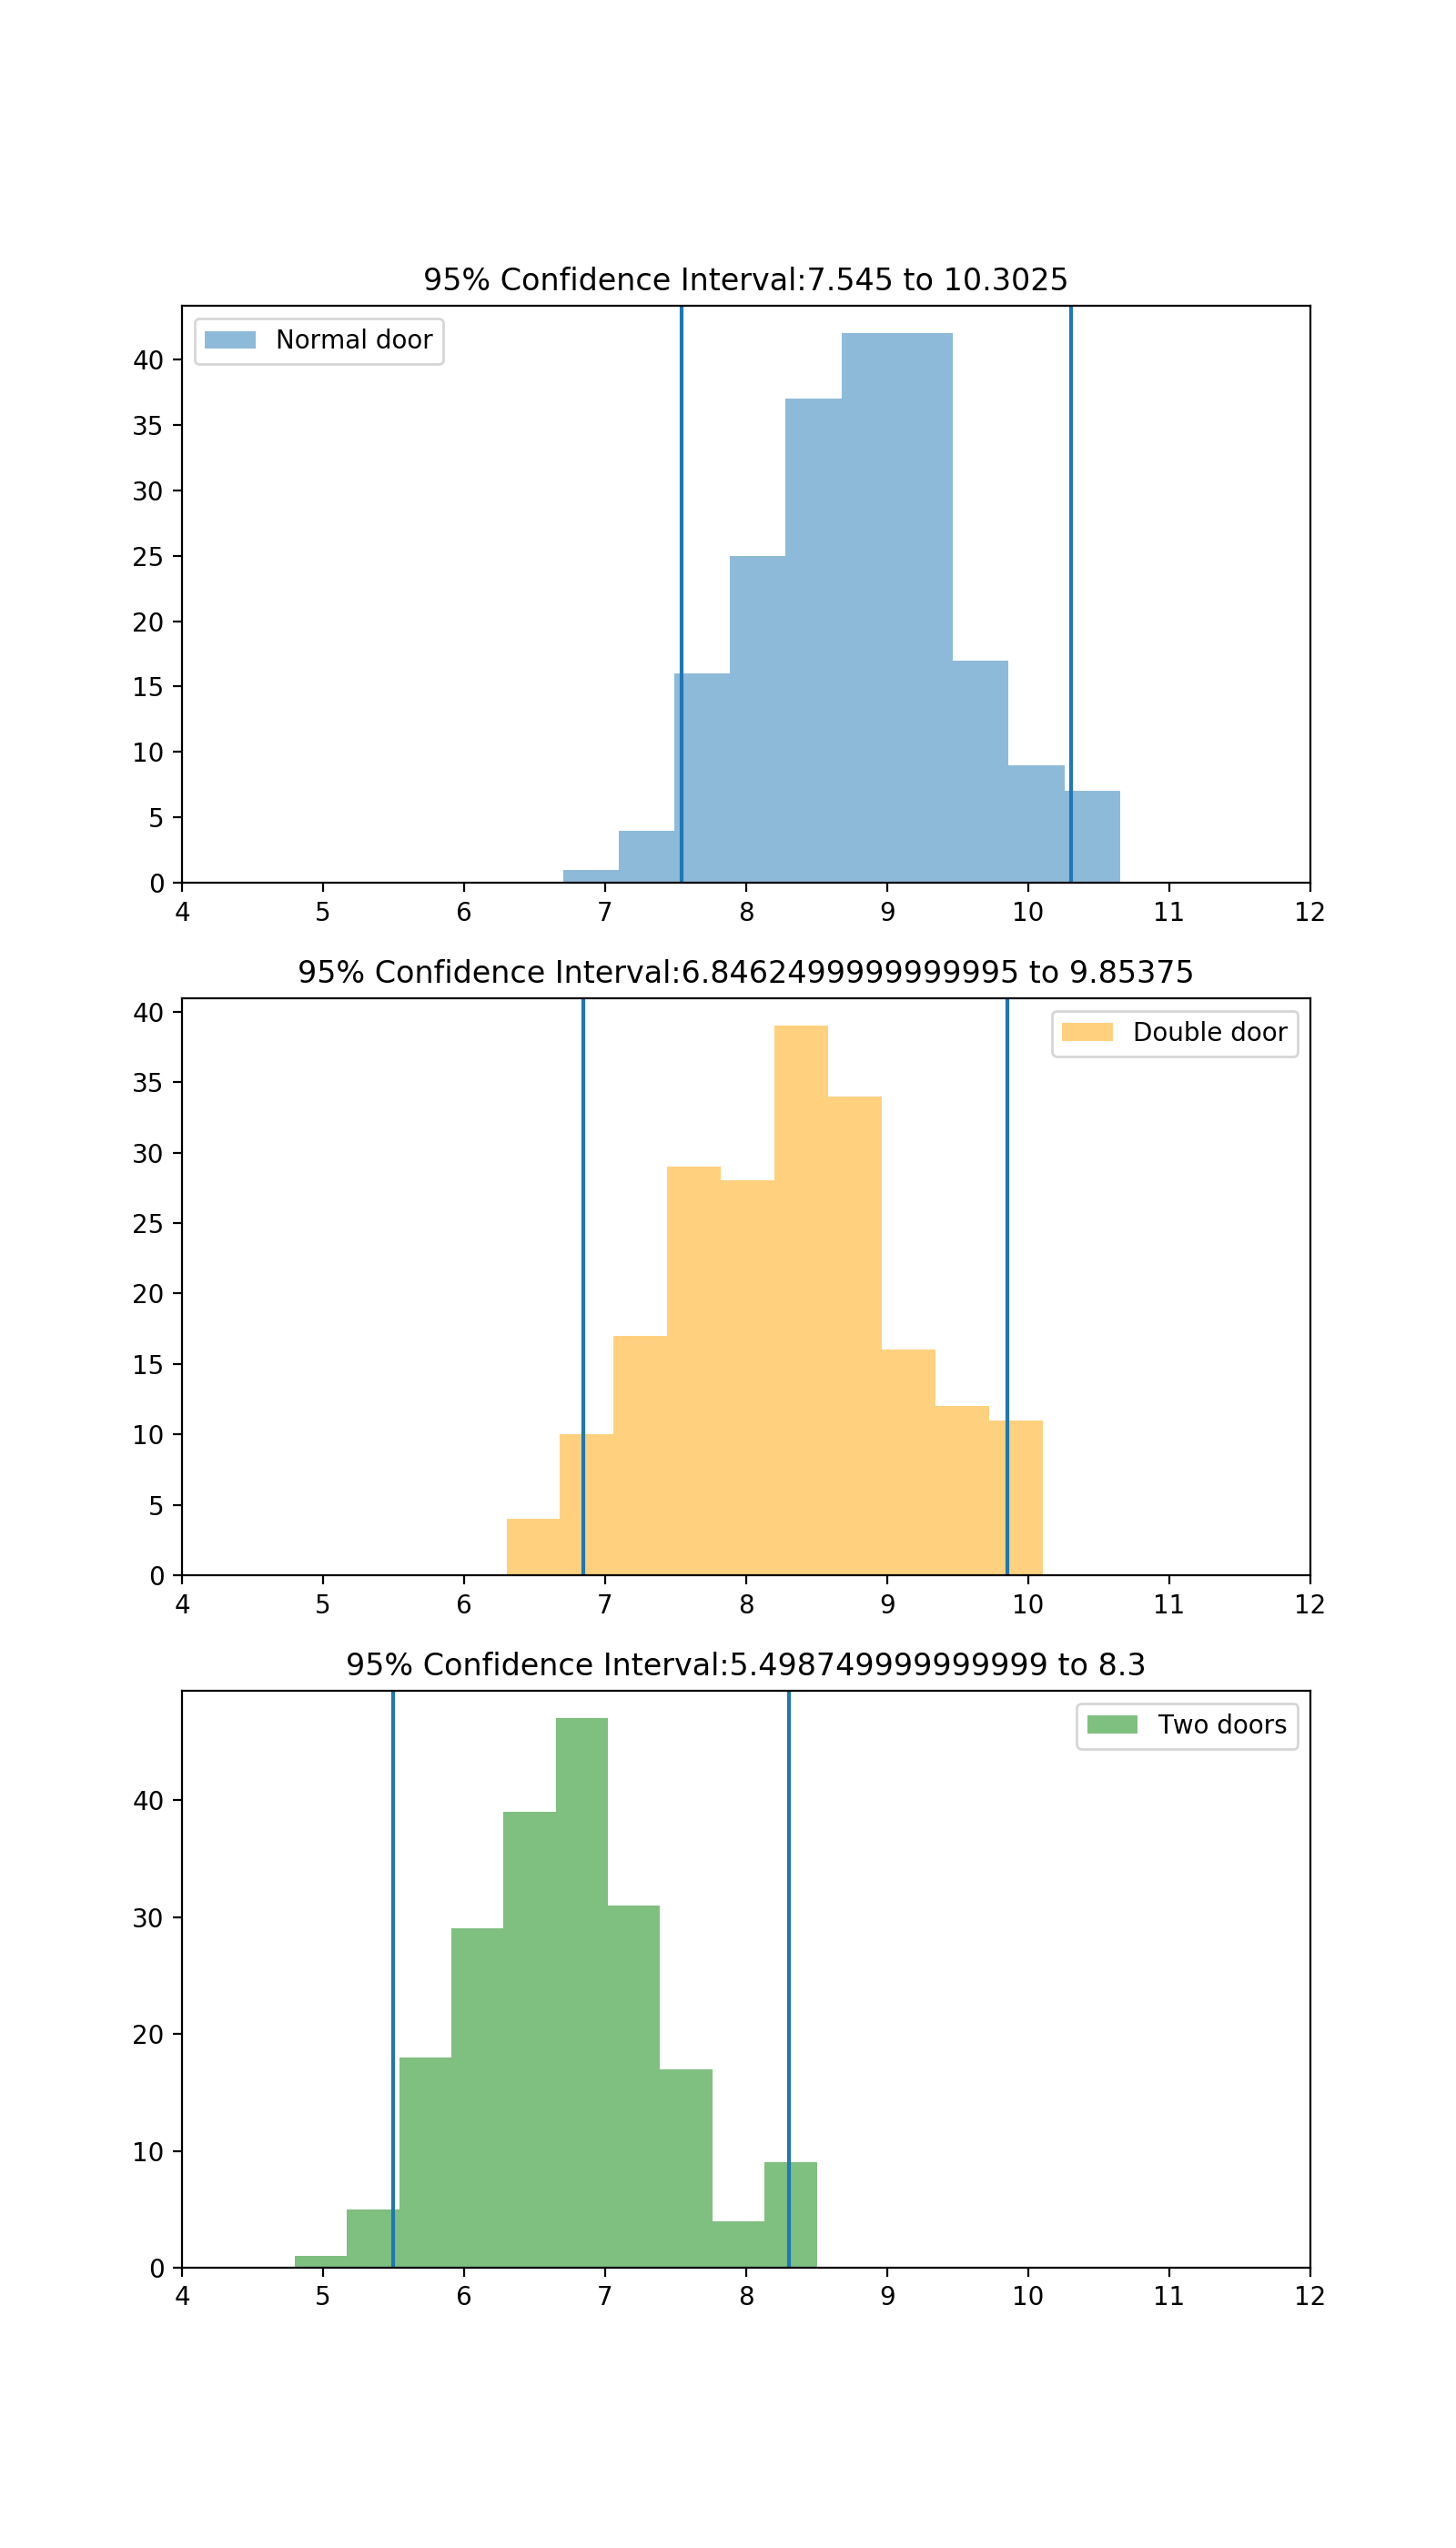

In [10]:
fig1b= plt.figure(figsize=(8,14))
plt.subplot(3, 1, 1)
plt.xlim((4, 12))
plt.hist(store1, alpha=0.5, label = 'Normal door')
plt.axvline(np.percentile(store1,2.5))
plt.axvline(np.percentile(store1,97.5))
plt.legend()
plt.title('95% Confidence Interval:'+str(np.percentile(store1,2.5))+' to '+str(np.percentile(store1,97.5)))

plt.subplot(3, 1, 2)
plt.hist(store_b, alpha=0.5, label = 'Double door', color = 'orange')
plt.xlim((4, 12))
plt.axvline(np.percentile(store_b,2.5))
plt.axvline(np.percentile(store_b,97.5))
plt.legend()
plt.title('95% Confidence Interval:'+str(np.percentile(store_b,2.5))+' to '+str(np.percentile(store_b,97.5)))


plt.subplot(3, 1, 3)
plt.hist(store_c, alpha=0.5, label = 'Two doors', color = 'green')
plt.xlim((4, 12))
plt.axvline(np.percentile(store_c,2.5))
plt.axvline(np.percentile(store_c,97.5))
plt.legend()
plt.title('95% Confidence Interval:'+str(np.percentile(store_c,2.5))+' to '+str(np.percentile(store_c,97.5)))

plt.show()
fig1b.savefig('fig1b.png')


In [19]:
store_b=[8.75,
 8.1,
 7.55,
 8.0,
 6.85,
 8.55,
 8.7,
 8.7,
 9.7,
 8.6,
 7.4,
 7.8,
 7.95,
 8.2,
 8.85,
 7.3,
 8.75,
 9.65,
 9.75,
 10.1,
 8.2,
 8.45,
 7.55,
 8.4,
 8.5,
 8.25,
 8.1,
 9.45,
 10.0,
 8.5,
 9.1,
 9.35,
 8.75,
 8.7,
 7.9,
 7.8,
 9.0,
 7.85,
 8.05,
 8.5,
 7.3,
 7.8,
 9.7,
 8.95,
 8.4,
 8.2,
 8.2,
 7.25,
 7.6,
 8.35,
 9.35,
 7.9,
 7.3,
 7.7,
 9.55,
 7.85,
 7.35,
 8.65,
 7.9,
 8.15,
 8.95,
 8.9,
 8.25,
 8.5,
 10.05,
 9.85,
 7.45,
 8.1,
 6.65,
 9.25,
 7.65,
 6.95,
 8.85,
 9.0,
 8.55,
 7.8,
 7.65,
 8.4,
 9.2,
 7.9,
 7.9,
 8.95,
 8.3,
 8.5,
 6.85,
 8.15,
 8.5,
 7.85,
 8.45,
 9.05,
 8.75,
 8.05,
 8.7,
 8.15,
 7.6,
 8.3,
 10.0,
 8.65,
 7.65,
 7.3,
 9.85,
 9.05,
 6.95,
 9.0,
 9.75,
 9.3,
 6.3,
 8.2,
 8.25,
 7.95,
 6.85,
 8.65,
 7.85,
 7.3,
 7.35,
 7.5,
 7.35,
 7.0,
 9.1,
 7.75,
 9.7,
 7.9,
 9.25,
 8.9,
 9.1,
 7.45,
 7.8,
 7.5,
 8.2,
 10.0,
 8.45,
 9.75,
 9.35,
 9.8,
 7.75,
 7.5,
 7.1,
 8.7,
 7.45,
 7.35,
 8.95,
 8.2,
 8.1,
 8.25,
 8.5,
 8.75,
 8.35,
 8.45,
 8.75,
 6.7,
 8.3,
 7.25,
 8.7,
 7.25,
 7.95,
 8.9,
 8.5,
 9.1,
 6.45,
 8.8,
 8.05,
 8.45,
 8.2,
 7.8,
 9.4,
 8.6,
 8.8,
 8.8,
 9.1,
 8.1,
 8.15,
 7.05,
 8.1,
 9.35,
 7.95,
 9.1,
 7.4,
 7.45,
 8.35,
 8.85,
 8.25,
 8.35,
 7.75,
 8.45,
 7.7,
 9.2,
 8.7,
 7.8,
 8.9,
 9.5,
 7.6,
 6.65,
 8.9,
 6.95,
 7.8,
 7.05,
 7.4,
 7.25,
 7.8,
 8.8]

In [20]:
store_c=[6.95,
 6.9,
 5.65,
 7.35,
 7.05,
 5.55,
 6.0,
 7.0,
 5.9,
 6.1,
 6.6,
 7.15,
 6.9,
 8.35,
 6.1,
 6.2,
 6.35,
 7.75,
 6.5,
 6.5,
 8.3,
 6.7,
 6.9,
 6.15,
 6.55,
 6.85,
 6.55,
 8.25,
 7.0,
 6.4,
 7.75,
 7.3,
 7.0,
 7.0,
 5.6,
 5.75,
 5.65,
 7.0,
 7.45,
 6.9,
 6.25,
 6.35,
 7.05,
 6.0,
 7.35,
 6.85,
 8.0,
 6.85,
 7.1,
 6.95,
 7.65,
 6.15,
 6.85,
 6.25,
 8.15,
 6.75,
 7.75,
 7.15,
 7.05,
 6.0,
 6.55,
 6.85,
 6.55,
 6.75,
 6.8,
 7.2,
 7.95,
 6.5,
 6.95,
 6.3,
 7.4,
 6.7,
 4.8,
 7.25,
 8.25,
 7.65,
 6.1,
 6.55,
 7.0,
 6.7,
 8.1,
 6.95,
 7.35,
 5.6,
 7.05,
 7.5,
 7.0,
 8.5,
 6.75,
 5.8,
 5.65,
 5.85,
 7.85,
 8.4,
 7.45,
 6.95,
 7.0,
 6.25,
 6.05,
 7.2,
 6.35,
 5.8,
 6.35,
 5.4,
 6.45,
 6.55,
 6.3,
 6.95,
 5.5,
 6.7,
 5.75,
 8.3,
 6.3,
 7.5,
 6.1,
 7.05,
 6.7,
 5.95,
 7.55,
 6.95,
 6.25,
 6.45,
 6.85,
 7.2,
 5.8,
 6.85,
 6.55,
 7.15,
 6.9,
 8.45,
 6.8,
 6.4,
 6.3,
 5.2,
 6.35,
 6.45,
 6.8,
 7.2,
 7.5,
 6.85,
 7.05,
 6.55,
 7.2,
 7.05,
 6.2,
 7.4,
 5.95,
 6.15,
 6.25,
 6.05,
 7.2,
 6.35,
 5.9,
 7.25,
 6.4,
 6.65,
 6.6,
 6.15,
 6.2,
 6.55,
 5.45,
 7.15,
 6.6,
 6.35,
 6.25,
 6.0,
 7.05,
 5.8,
 5.25,
 6.35,
 7.4,
 6.3,
 7.55,
 6.75,
 6.7,
 6.4,
 7.0,
 6.4,
 6.45,
 7.2,
 7.4,
 7.15,
 6.15,
 5.85,
 6.4,
 6.0,
 7.15,
 7.15,
 6.45,
 5.95,
 6.9,
 7.65,
 6.75,
 7.3,
 6.7,
 7.2,
 6.1,
 5.7,
 7.0,
 5.8]

In [21]:
store3=[10.15,
 9.55,
 10.4,
 11.1,
 10.35,
 10.0,
 11.35,
 10.05,
 10.1,
 9.2,
 10.75,
 10.95,
 9.4,
 12.1,
 8.95,
 11.5,
 9.35,
 11.1,
 10.45,
 9.8,
 9.45,
 9.6,
 9.1,
 11.0,
 10.35,
 11.15,
 9.4,
 8.6,
 10.7,
 11.1,
 8.9,
 10.35,
 10.95,
 9.4,
 9.55,
 10.05,
 10.2,
 9.85,
 9.8,
 9.05,
 10.2,
 9.85,
 10.25,
 10.15,
 9.3,
 10.1,
 9.85,
 8.65,
 9.25,
 8.85,
 10.75,
 9.4,
 8.9,
 8.95,
 10.4,
 9.8,
 10.55,
 9.85,
 8.05,
 10.55,
 11.35,
 8.6,
 10.5,
 9.5,
 10.15,
 10.35,
 9.95,
 9.05,
 10.25,
 10.4,
 9.3,
 9.5,
 11.05,
 10.5,
 10.05,
 9.0,
 10.25,
 11.65,
 10.65,
 9.35,
 9.75,
 10.1,
 10.4,
 8.5,
 9.5,
 10.1,
 9.35,
 10.55,
 11.45,
 10.6,
 11.65,
 10.3,
 10.5,
 9.2,
 10.15,
 10.85,
 11.25,
 10.15,
 9.2,
 9.65,
 9.7,
 11.0,
 10.45,
 11.15,
 10.1,
 9.9,
 8.05,
 9.05,
 9.3,
 9.85,
 8.35,
 10.0,
 9.05,
 9.0,
 10.75,
 10.3,
 10.75,
 11.7,
 10.0,
 11.3,
 10.3,
 9.2,
 9.45,
 9.15,
 10.6,
 10.25,
 9.85,
 11.0,
 9.05,
 9.15,
 9.35,
 9.45,
 10.1,
 11.0,
 10.15,
 11.75,
 9.95,
 11.75,
 9.95,
 9.8,
 8.1,
 11.8,
 10.85,
 9.05,
 9.35,
 11.35,
 12.05,
 8.9,
 9.35,
 9.5,
 8.75,
 9.7,
 10.25,
 10.05,
 10.35,
 9.65,
 10.75,
 9.65,
 9.6,
 10.1,
 9.55,
 11.25,
 10.45,
 9.0,
 11.75,
 9.3,
 10.4,
 10.15,
 8.7,
 8.6,
 10.1,
 8.55,
 9.0,
 10.3,
 10.25,
 10.6,
 10.4,
 9.35,
 10.05,
 9.1,
 10.0,
 10.3,
 9.15,
 9.05,
 9.45,
 11.35,
 10.5,
 10.5,
 8.9,
 10.8,
 9.85,
 11.0,
 8.85,
 9.65,
 11.3,
 10.45,
 9.3,
 8.85,
 10.0,
 10.75]



In [22]:
store1 = [9.15,
 8.4,
 9.9,
 9.05,
 8.3,
 8.85,
 8.65,
 9.0,
 8.0,
 8.55,
 9.85,
 8.45,
 9.1,
 8.85,
 7.65,
 8.55,
 9.65,
 10.0,
 9.75,
 8.95,
 8.65,
 10.3,
 7.9,
 9.0,
 9.3,
 8.9,
 9.75,
 9.05,
 9.1,
 8.75,
 7.95,
 8.7,
 9.0,
 8.55,
 8.35,
 9.25,
 8.85,
 8.25,
 7.95,
 7.8,
 8.6,
 8.2,
 8.45,
 9.5,
 7.6,
 8.9,
 10.55,
 10.25,
 9.8,
 9.4,
 10.5,
 7.35,
 9.55,
 8.3,
 10.25,
 8.9,
 9.3,
 7.75,
 9.4,
 8.75,
 8.5,
 7.8,
 8.95,
 10.65,
 8.95,
 8.95,
 9.4,
 9.75,
 10.25,
 8.3,
 9.4,
 9.35,
 9.1,
 7.95,
 9.4,
 8.85,
 8.25,
 10.4,
 9.0,
 9.1,
 8.7,
 8.8,
 8.4,
 8.75,
 9.45,
 8.35,
 9.45,
 7.8,
 8.8,
 9.45,
 9.85,
 8.45,
 9.6,
 8.0,
 8.35,
 8.85,
 9.15,
 7.55,
 7.65,
 9.4,
 9.55,
 8.85,
 7.85,
 9.3,
 9.35,
 8.55,
 7.8,
 8.4,
 7.9,
 9.25,
 8.15,
 8.8,
 9.25,
 9.6,
 7.9,
 7.35,
 8.6,
 8.55,
 8.75,
 9.25,
 9.4,
 8.55,
 8.7,
 9.25,
 9.1,
 6.7,
 8.55,
 8.15,
 9.3,
 9.3,
 8.55,
 8.45,
 9.25,
 8.8,
 9.3,
 9.95,
 8.3,
 8.85,
 7.25,
 8.05,
 8.4,
 9.0,
 9.4,
 9.4,
 8.85,
 8.15,
 9.45,
 8.35,
 8.4,
 9.15,
 7.7,
 9.3,
 8.85,
 8.95,
 8.55,
 7.6,
 9.6,
 9.85,
 9.55,
 7.75,
 9.2,
 7.9,
 9.85,
 8.2,
 8.8,
 9.3,
 7.2,
 8.95,
 10.65,
 7.95,
 7.9,
 9.65,
 7.8,
 8.85,
 9.2,
 8.45,
 8.4,
 9.35,
 9.0,
 8.4,
 8.55,
 7.95,
 7.8,
 7.95,
 8.2,
 8.8,
 8.45,
 7.8,
 8.0,
 10.2,
 9.95,
 9.1,
 9.05,
 8.1,
 10.3,
 9.15,
 8.3,
 8.05,
 10.25,
 8.85]

In [23]:
store2=[10.2,
 7.5,
 8.85,
 8.1,
 8.8,
 8.35,
 9.05,
 8.05,
 8.2,
 7.05,
 8.85,
 8.9,
 9.05,
 9.35,
 8.25,
 8.8,
 8.8,
 8.8,
 9.2,
 8.25,
 9.1,
 8.75,
 8.8,
 8.35,
 9.25,
 8.7,
 8.55,
 8.2,
 9.1,
 8.9,
 9.5,
 7.75,
 8.6,
 8.85,
 8.5,
 7.95,
 8.25,
 9.95,
 8.95,
 8.4,
 7.95,
 9.6,
 9.9,
 10.1,
 10.75,
 9.75,
 8.65,
 8.9,
 9.65,
 8.65,
 7.85,
 9.4,
 10.2,
 8.3,
 9.75,
 8.95,
 8.95,
 8.5,
 7.4,
 9.0,
 9.1,
 9.15,
 8.05,
 9.4,
 8.25,
 8.0,
 8.95,
 9.1,
 9.35,
 8.8,
 9.15,
 8.05,
 8.6,
 8.15,
 9.55,
 9.05,
 8.3,
 7.85,
 10.4,
 9.5,
 9.25,
 9.45,
 9.9,
 7.45,
 7.9,
 8.8,
 8.65,
 9.3,
 9.55,
 10.3,
 8.7,
 9.0,
 8.9,
 10.6,
 7.85,
 9.65,
 8.25,
 8.35,
 9.2,
 8.9,
 8.35,
 9.35,
 8.3,
 8.7,
 8.7,
 9.05,
 8.55,
 8.85,
 7.85,
 7.8,
 9.45,
 6.95,
 7.75,
 8.15,
 7.15,
 8.25,
 8.15,
 8.15,
 9.35,
 9.95,
 9.4,
 7.55,
 9.1,
 8.05,
 7.1,
 9.5,
 8.3,
 8.85,
 8.7,
 8.15,
 9.25,
 8.05,
 9.75,
 8.35,
 9.85,
 9.5,
 10.55,
 7.9,
 10.55,
 9.15,
 9.0,
 8.7,
 8.5,
 9.2,
 8.3,
 8.4,
 8.75,
 9.2,
 7.8,
 8.85,
 8.15,
 8.35,
 9.25,
 8.35,
 7.85,
 8.7,
 8.85,
 9.1,
 8.4,
 8.1,
 9.15,
 8.55,
 8.7,
 9.35,
 8.25,
 8.15,
 8.15,
 9.45,
 8.85,
 7.35,
 8.9,
 7.35,
 8.3,
 9.05,
 8.5,
 8.95,
 8.6,
 9.95,
 7.95,
 8.4,
 7.7,
 9.3,
 8.8,
 9.8,
 8.45,
 9.15,
 7.4,
 8.7,
 8.2,
 9.1,
 8.45,
 10.7,
 10.55,
 9.7,
 10.0,
 9.25,
 9.5,
 8.2,
 10.2,
 7.25]
